In [306]:
import scipy as sp
import scipy.optimize as op
import numpy as np
import pylab as pl
import emcee
from scipy.special import erfc
from lmfit.models import SkewedGaussianModel
%matplotlib inline

In [307]:
filename = 'run562.txt'
infile = open(filename,'r')

xvals=[];ymeas=[]
while True:
    line = infile.readline()
    if not line: break
        
    items = line.split()
    xvals.append(float(items[0]))
    ymeas.append(float(items[1]))
    
xvals = np.array(xvals[2000:2300])
ymeas = np.array(ymeas[2000:2300])

infile.close()

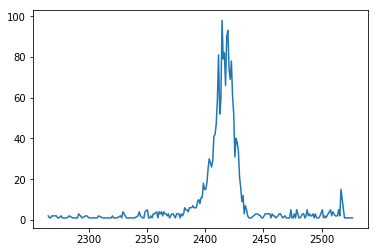

In [308]:
pl.subplot(111)
pl.plot(xvals,ymeas)
pl.show()

---

https://lmfit.github.io/lmfit-py/builtin_models.html#skewedgaussianmodel

In [309]:
'''
def gauss_fn(p0, x):
    
    amp,mu,sigma,gamma = p0
    model = SkewedGaussianModel()
        #amp*=sigma*np.sqrt(2*np.pi)
    
    # set initial parameter values
    params = model.make_params(amplitude=amp, center=mu, sigma=sigma, gamma=gamma)
    ymod = model.eval(params=params,x=x)
    
    return ymod
'''

def gf3(p0, x):
    #this is the fuctional form that we have been using in our manual fit
    #it is the sum of a gaussian and a skewed gaussian with the same mean
    #the extra parameters r and beta are introduced
    #r is the fraction of the height of the skewed gaussian given as a pecentage
    #beta is the 'skewneess' of the second skew gaussian
    #it is the decay constant of an exponential tail on the skewed gaussian
    #this exponential tail is convolved with a gaussian resolution function
    
    amp, mu, sigma, r, beta = p0
    
    #gaussian part
    ygaus = amp * (1 - r/100) * np.exp((-(x - mu)**2)/(2 * sigma**2))
    
    #'skew' gaussian part. erfc is 1 - the error function
    yskew = amp * (r/100) * np.exp((x-mu)/beta) * erfc( (x-mu)/(sigma * np.sqrt(2))  + sigma/(beta*np.sqrt(2)))
    #yskew = 0
    #ygaus = 0
    ymod = yskew + ygaus
    
    return ymod

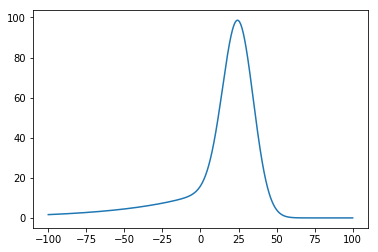

In [407]:
#test to see if this function looks correct
x = np.arange(-100, 100, step = 0.001)
y = gf3([100, 25, 10, 10,50],x)

#y = np.exp(((x-5)/5)) * erfc(((x-5)/(10*2**0.5)) + 2/(5*2**0.5 ))
pl.plot(x,y)

pl.show()

In [311]:
def lnlike(p0, x, y):
    
    # get model for these parameters:
    #ymod = gauss_fn(p0,x)
    ymod = gf3(p0,x)
    
    # Poisson loglikelihood:
    ll = np.sum(ymod[np.where(ymeas!=0)]*np.log(ymeas[np.where(ymeas!=0)])) - np.sum(ymeas) - np.sum(ymod[np.where(ymod!=0)]*np.log(ymod[np.where(ymod!=0)]) - ymod[np.where(ymod!=0)])
    
    return ll

In [345]:
# use maxvalue to guess amplitude:
a0 = np.max(ymeas)

# use position of maxvalue to guess mean:
m0 = xvals[np.argmax(ymeas)]

# just guess width:
s0 = 10.

# just guess r and beta from what they usually turn out about from experience
r0 = 10.
b0 = 5.

# adjust the amplitude for the normalisation factor:
#a0*=s0*np.sqrt(2*np.pi)

print(a0,m0,s0,r0,b0)
p0 = np.array([a0,m0,s0,r0,b0])

98.0 2414.5 10.0 10.0 5.0


In [364]:
bnds = ((None,None), (None,None), (0.1,None), (0.1, 100), (0.1,None))

print(len(p0))
print(len(bnds))

5
5


In [365]:
nll = lambda *args: -lnlike(*args)

result = op.minimize(nll, p0, bounds=bnds, args=(xvals, ymeas))
p1 = result["x"]

In [366]:
print(p1)

[  80.73747849 2416.82208227    7.8886751     3.96835569   65.05658563]


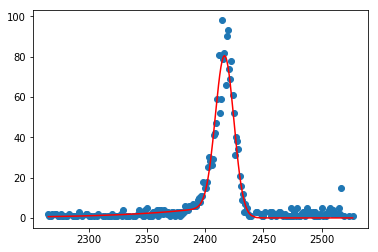

-214.98713784458505


In [367]:
yfit = gf3(p1,xvals)
pl.subplot(111)
pl.scatter(xvals,ymeas)
pl.plot(xvals,yfit,c='r')
pl.show()

print(lnlike(p1, xvals, ymeas))

Text(0,0.5,'$\\sigma$')

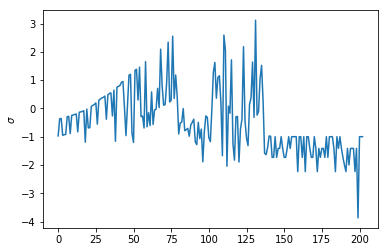

In [368]:
res = (yfit - ymeas)/np.sqrt(ymeas)
pl.plot(res)
pl.ylabel(r"$\sigma$")

These residuals still look weird.

---

In [390]:
ndim, nwalkers = 5, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [391]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, args=(xvals, ymeas))

In [392]:
p0 = sampler.run_mcmc(pos, 100) #this doesn't work with 500 as it tries to use a negative value of r

In [401]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
print(samples.shape)

(5000, 5)


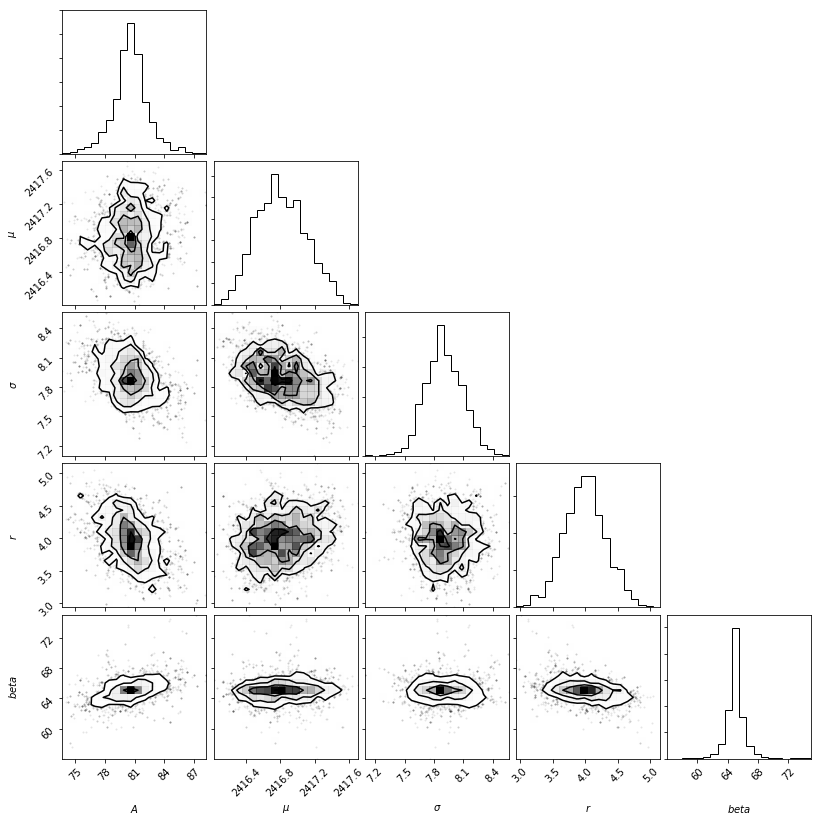

In [406]:
import corner

fig = corner.corner(samples, labels=["$A$", "$\mu$", "$\sigma$","$r$", "$beta$"],
                      truths=[a0, m0, s0, r0, b0])
fig.savefig("triangle.png")